In [1]:
!pip install monai
!pip3 install nibabel
!pip3 install torch
!pip3 install sklearn
!pip3 install tqdm


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your depende

In [4]:
import os
import shutil
import matplotlib.pyplot as plt
import PIL
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
)
from monai.utils import set_determinism
import os
import nibabel as nib
from sklearn.model_selection import train_test_split
from monai.config import print_config
from monai.inferers import SliceInferer
from monai.networks.nets import UNet
from tqdm import tqdm
#print_config()

RuntimeError: Only a single TORCH_LIBRARY can be used to register the namespace triton; please put all of your definitions in a single TORCH_LIBRARY block.  If you were trying to specify implementations, consider using TORCH_LIBRARY_IMPL (which can be duplicated).  If you really intended to define operators for a single namespace in a distributed way, you can use TORCH_LIBRARY_FRAGMENT to explicitly indicate this.  Previous registration of TORCH_LIBRARY was registered at /dev/null:2504; latest registration was registered at /dev/null:2504

In [2]:
#T1 dataset :https://brain-development.org/ixi-dataset/
# Define your NIfTI image directory
image_dir = "/home/sayadkouhs/Desktop/dataset/IXI-T1"
print(image_dir)


/home/sayadkouhs/Desktop/dataset/IXI-T1


In [3]:
# Load each image separately and store it in a list
image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.nii.gz')]
print(f"Total NIfTI files found: {len(image_paths)}")
images = []
#for path in image_paths:
#    img = LoadImage(image_only=True, reader="NibabelReader", squeeze_non_spatial_dims=True)(path)
#    images.append(img)
#nibabelreader used for the .nii.gz images.

Total NIfTI files found: 581


In [4]:
import torch
from monai.transforms import LoadImage, EnsureChannelFirst, Compose, ToTensor
from monai.networks.nets import UNet
from monai.inferers import SliceInferer
import sys
print(sys.version, sys.platform, sys.executable)
from tqdm import tqdm
from monai.transforms import LoadImage, EnsureChannelFirst, Compose,Resize

import numpy as np
# Define the target shape
TARGET_SHAPE = (256, 256, 150)  # (H, W, D)

# Add Resize to the transformation pipeline
transform = Compose([
    LoadImage(image_only=True, reader="NibabelReader", squeeze_non_spatial_dims=True),
    EnsureChannelFirst(),
    Resize(spatial_size=TARGET_SHAPE),  # Resize to target shape
])

# Load and transform images
input_volumes = []
for image_path in range(int(len(image_paths)/12)):
    input_volume = transform(image_paths[image_path])  # Shape: (C, D, H, W)
    input_volumes.append(input_volume)

# Stack the list into a single tensor with shape (N, C, D, H, W)
input_volumes = torch.stack(input_volumes, dim=0)

print("Input volumes shape: ", input_volumes.shape)  # Should be (N, C, D, H, W)

# Define the 2D U-Net model
net = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(4, 8, 16),
    strides=(2, 2),
    num_res_units=2,
)

# Perform inference along the axial plane (D axis)
axial_inferer = SliceInferer(roi_size=(256, 256), sw_batch_size=1, spatial_dim=2, cval=-1, progress=True)
axial_output = axial_inferer(input_volumes, net)  # Output shape: (N, C, D, H, W)
print("Axial Inferer Output Shape: ", axial_output.shape)

# Perform inference along the coronal plane (H axis)
#coronal_inferer = SliceInferer(
#    roi_size=(256, 256), sw_batch_size=1, spatial_dim=3, cval=-1, progress=True
#)
#coronal_output = coronal_inferer(input_volumes, net)  # Output shape: (N, C, D, H, W)
#print("Coronal Inferer Output Shape: ", coronal_output.shape)



3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0] linux /bin/python3
Input volumes shape:  torch.Size([48, 1, 256, 256, 150])


100%|██████████| 7200/7200 [00:46<00:00, 155.66it/s]

Axial Inferer Output Shape:  torch.Size([48, 1, 256, 256, 150])


In [5]:
print(axial_output.shape)

axial_middle_slice_index = axial_output.shape[2] // 2



torch.Size([48, 1, 256, 256, 150])


(256, 150)
(256, 150)


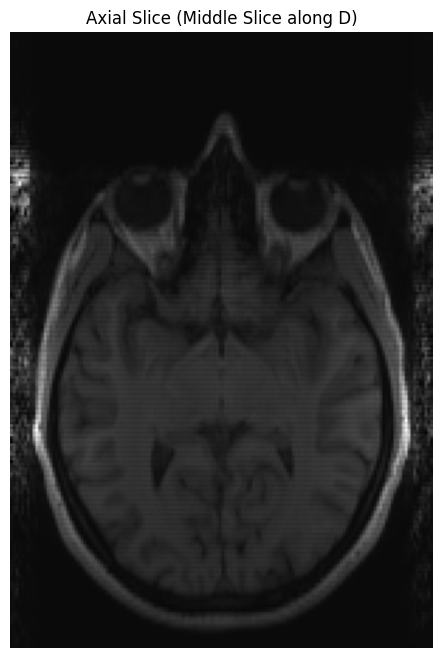

In [59]:

# Normalize and extract the middle slice
axial_middle_slice_index = axial_output.shape[2] // 2  # Middle slice along the D axis
#coronal_middle_slice_index = coronal_output.shape[3] // 2  # Middle slice along the H axis

# Extract and normalize the slices
axial_slice = axial_output[1, 0, :, axial_middle_slice_index,:].cpu().detach().numpy()
#coronal_slice = coronal_output[0, 0, :, coronal_middle_slice_index, :].cpu().detach().numpy()
print(axial_slice.shape)
# Normalize the slices to [0, 1] for better visualization
axial_slice = (axial_slice - np.min(axial_slice)) / (np.max(axial_slice) - np.min(axial_slice))
#coronal_slice = (coronal_slice - np.min(coronal_slice)) / (np.max(coronal_slice) - np.min(coronal_slice))

print(axial_slice.shape)
#print("Axial slice shape :",axial_slice.shape,"Coronal slice shape: ",coronal_slice.shape )
# Plot both axial and coronal slices
plt.figure(figsize=(12, 8))

# Plot the axial slice
plt.subplot(1, 2, 1)
plt.imshow(axial_slice,aspect='auto',cmap="gray")
plt.title("Axial Slice (Middle Slice along D)")
plt.axis('off')

# Plot the coronal slice
#plt.subplot(1, 2, 2)
#plt.imshow(coronal_slice,  cmap='plasma',aspect='auto')
#plt.title("Coronal Slice (Middle Slice along H)")
#plt.axis('off')

plt.show()

torch.Size([1, 1, 256, 256])


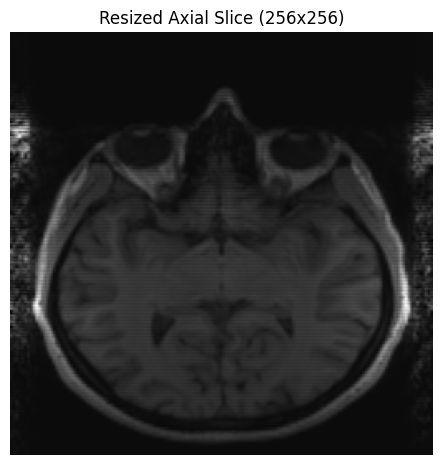

In [61]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt




# Convert to tensor
axial_slice_tensor = torch.tensor(axial_slice).unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, H, W)
#coronal_slice_tensor = torch.tensor(coronal_slice).unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, H, W)

# Resize to (256, 256) using F.interpolate
axial_resized = F.interpolate(axial_slice_tensor, size=(256, 256), mode='bilinear', align_corners=False)
#coronal_resized = F.interpolate(coronal_slice_tensor, size=(256, 256), mode='bilinear', align_corners=False)
print(axial_resized.shape)
# Convert back to numpy for visualization
axial_resized_np = axial_resized.squeeze().cpu().detach().numpy()
#coronal_resized_np = coronal_resized.squeeze().cpu().detach().numpy()

# Plot the resized slices
plt.figure(figsize=(12, 8))

# Plot the axial slice
plt.subplot(1, 2, 1)
plt.imshow(axial_resized_np, cmap='gray')
plt.title("Resized Axial Slice (256x256)")
plt.axis('off')

# Plot the coronal slice
#plt.subplot(1, 2, 2)
#plt.imshow(coronal_resized_np, cmap='plasma')
#plt.title("Resized Coronal Slice (256x256)")
#plt.axis('off')

plt.show()


In [62]:
#for multiple image. 
print(axial_resized.shape)
print(axial_slice.shape)

torch.Size([1, 1, 256, 256])
(256, 150)


In [6]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class GaussianBlur(nn.Module):
    def __init__(self, kernel_size=5, sigma=1.0):
        super(GaussianBlur, self).__init__()
        
        # Store kernel size and sigma for later use
        self.kernel_size = kernel_size
        self.sigma = sigma
        self.padding = kernel_size // 2  # Padding to maintain the input shape

        # Create the Gaussian kernel (will be used in the forward pass)
        self.register_buffer('kernel', self.create_gaussian_kernel())

    def create_gaussian_kernel(self):
        # Create a 2D Gaussian kernel using the formula
        ax = np.linspace(-(self.kernel_size // 2), self.kernel_size // 2, self.kernel_size)
        xx, yy = np.meshgrid(ax, ax)

        kernel = np.exp(-(xx**2 + yy**2) / (2.0 * self.sigma**2))
        kernel = kernel / np.sum(kernel)  # Normalize to ensure the sum is 1

        # Convert to a tensor
        return torch.tensor(kernel, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    def forward(self, x):
        # Apply Gaussian blur to the input tensor
        # We use the conv2d layer to perform the blur
        return F.conv2d(x, self.kernel, padding=self.padding, groups=x.shape[1])



# Initialize the GaussianBlur layer
gaussian_blur = GaussianBlur(kernel_size=5, sigma=1.0)


shape (256, 256)


/tmp/ipykernel_371733/3179482198.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  axial_resized_tensor = torch.tensor(axial_resized, dtype=torch.float32)  # Shape: [1, 1, 256, 256]


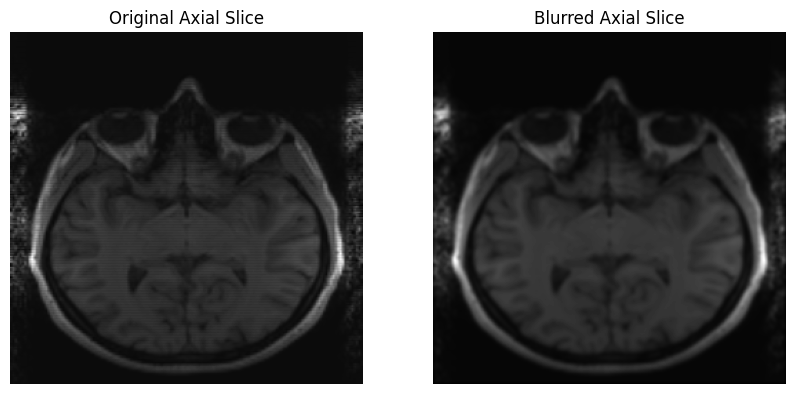

In [64]:
# Example: Assume you have a list of axial slices (e.g., axial_slices)
slices = [axial_resized]  # List of axial slices

import torch
import numpy as np
import matplotlib.pyplot as plt


# Convert the numpy array to a PyTorch tensor
axial_resized_tensor = torch.tensor(axial_resized, dtype=torch.float32)  # Shape: [1, 1, 256, 256]

# Apply the Gaussian blur (assuming gaussian_blur is defined already)
blurred_axial_resized = gaussian_blur(axial_resized_tensor)  

# Convert the result to a numpy array for visualization
blurred_axial_resized_numpy = blurred_axial_resized.squeeze(0).squeeze(0).cpu().detach().numpy()


plt.figure(figsize=(10, 5))

# Original image (Squeeze to 2D for imshow)
axial_resized_2d = axial_resized_tensor.squeeze(0).squeeze(0).cpu().detach().numpy()  # Convert to 2D
print("shape",axial_resized_2d.shape)
plt.subplot(1, 2, 1)
plt.imshow(axial_resized_2d, cmap='gray')
plt.title("Original Axial Slice")
plt.axis('off')

# Blurred image
plt.subplot(1, 2, 2)
plt.imshow(blurred_axial_resized_numpy, cmap='gray')
plt.title("Blurred Axial Slice")
plt.axis('off')

plt.show()




The CNN model, F, for correction had an input and output size of 256 × 256 × 1. The
architecture was a U-Net (Ronneberger et al., 2015) with five down-sampling levels. Each
down-sampling block contains two convolutional layers with symmetric padding and ReLU
activations (Glorot et al., 2011), Batch Normalization (Ioffe and Szegedy, 2014) and for
down-sampling to half the size, the model used Max Pooling layers. Each up-sampling
layer is constructed similarly using a bilinear upsampling layer, and an additional Gaussian
blur layer. The final output is constrained to values between 0.5 and 2

In [7]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
# Define U-Net architecture
class CustomUNet(nn.Module):
    def __init__(self):
        super(CustomUNet, self).__init__()
        
        # Define the down-sampling path (Encoder)
        self.down1 = self.conv_block(1, 64)  # (1, 64)
        self.down2 = self.conv_block(64, 128)  # (64, 128)
        self.down3 = self.conv_block(128, 256)  # (128, 256)
        self.down4 = self.conv_block(256, 512)  # (256, 512)
        self.down5 = self.conv_block(512, 1024)  # (512, 1024)

        # Define the up-sampling path (Decoder)
        self.up5 = self.deconv_block(1024, 512)  # (1024, 512)
        self.up4 = self.deconv_block(512, 256)  # (512, 256)
        self.up3 = self.deconv_block(256, 128)  # (256, 128)
        self.up2 = self.deconv_block(128, 64)  # (128, 64)
        self.up1 = self.deconv_block(64, 1)  # (64, 1)

        # Gaussian Blur Layer
        self.gaussian_blur = GaussianBlur(kernel_size=5, sigma=1.0)

    def conv_block(self, in_channels, out_channels):
        # A block of convolutional layers with BatchNorm and ReLU
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Max Pooling to downsample
        )

    def deconv_block(self, in_channels, out_channels):
            # A block of up-convolutions with Bilinear Upsampling using F.interpolate
            return nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                nn.Conv2d(in_channels, out_channels, kernel_size=1),  # 1x1 convolution to match channels
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
    )

    def forward(self, x):
        # Down-sampling (Encoder)
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        x5 = self.down5(x4)

        # Up-sampling (Decoder)
        x = self.up5(x5)
        x = self.up4(x)
        x = self.up3(x)
        x = self.up2(x)
        x = self.up1(x)

        # Apply Gaussian blur after up-sampling
        x = self.gaussian_blur(x)

        # Clamp the output to be between 0.5 and 2
        return torch.clamp(x, min=0.5, max=2.0)





In [13]:
def output_range(x):
    rng = 1
    x = torch.where(x > -rng, x, -rng * torch.ones_like(x))
    x = torch.where(x < rng, x, rng * torch.ones_like(x))
    return x
#input is torch.tensor 

# PSNR function to evaluate image quality
def psnr(y_true, y_pred):

    if isinstance(y_true, np.ndarray):
        y_true = torch.tensor(y_true)
    if isinstance(y_pred, np.ndarray):
        y_pred = torch.tensor(y_pred)

    mse = torch.mean((y_true - y_pred) ** 2)
    PIXEL_MAX = 1.0  # original is 255 but (gt)Normalized image pixel range [0, 1]
    return 20 * torch.log10(PIXEL_MAX / torch.sqrt(mse))


def implicit_relation(tensor):
    a = tensor[0]
    b = tensor[1]
    # Ensure both tensors are on the same device
    if a.device != b.device:
        b = b.to(a.device)
    c = a - b
    return c



def implicit_correction(tensor):

    if isinstance(tensor, np.ndarray):#ensure that is tensor.
        tensor = torch.tensor(tensor)

    c = tensor 
    
    # Compute the minimum along axes (1, 2, 3)
    c_min = torch.min(c, dim=1, keepdim=True).values
    c = c + c_min  
    
    # Compute the maximum along axes (1, 2, 3)
    c_max = torch.max(c, dim=1, keepdim=True).values
    c = c / (c_max + 1e-8)  # Adding epsilon for numerical stability
    
    return c

(-0.5, 255.5, 255.5, -0.5)

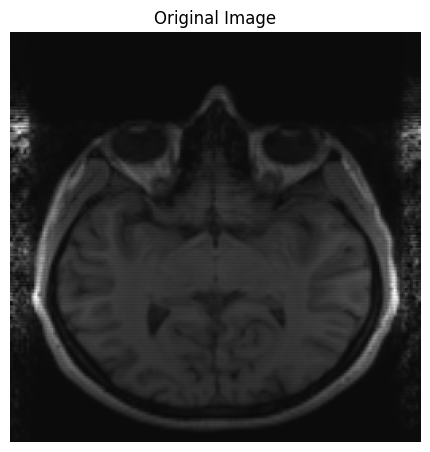

In [66]:


# Convert to numpy for visualization
original_image_np = axial_resized.squeeze().cpu().numpy()

# Plot the images
plt.figure(figsize=(18, 6))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(original_image_np, cmap='gray')
plt.title("Original Image")
plt.axis('off')

In [12]:


# Create an empty list to store the slices
slices = []
input_tensor=axial_output
# Loop through each image in the tensor
for i in range(input_tensor.shape[0]):
    # Select the middle slice along the depth dimension
    middle_slice_index = input_tensor.shape[4] // 2  # Middle index along D (depth)
    
    # Extract the middle slice (shape: [1, 256, 256]) for each image
    slice = input_tensor[i, :, :, :, middle_slice_index]
    
    # Add the slice to the list
    slices.append(slice.unsqueeze(0))  # Add a batch dimension to make it [1, 1, 256, 256]

# Stack the list of slices into a single tensor (shape: [48, 1, 1, 256, 256])
output_tensor = torch.cat(slices, dim=0)

# Verify the output shape
print(output_tensor.shape)

torch.Size([48, 1, 256, 256])


In [8]:
from monai.transforms import RandBiasField
import torch
import matplotlib.pyplot as plt

def noise_(img, degree=1, coeff_range=(0.0, 0.1), prob=1.0):
    """
    Add bias field noise to an image.
    :param img: The input image tensor.
    :param degree: The degree of the bias field (controls the spatial frequency of the noise).
    :param coeff_range: Range of the coefficients to scale the bias field.
    :param prob: The probability of applying the noise.
    :return: Noisy image and the extracted noise.
    """
    # Initialize the bias field noise transformation
    noise_transform = RandBiasField(degree=degree, coeff_range=coeff_range, prob=prob)
    
    # Apply the noise transformation to the image
    noisy_image = noise_transform(img)
    
    # Extract the noise by subtracting the original image from the noisy image
    noise = noisy_image - img
    return noisy_image, noise






"""

print(axial_resized.shape)
# Add bias field noise
Image_with_noise = noise_(axial_resized)

# Convert to numpy for visualization
original_image_np = axial_resized.squeeze().cpu().detach().numpy()
noisy_image_np = Image_with_noise[0].squeeze().cpu().detach().numpy()
noise_np = Image_with_noise[1].squeeze().cpu().detach().numpy()

# Plot the images
plt.figure(figsize=(18, 6))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(original_image_np, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Noisy Image
plt.subplot(1, 3, 2)
plt.imshow(noisy_image_np, cmap='gray')
plt.title("Noisy Image")
plt.axis('off')

# Noise Image
plt.subplot(1, 3, 3)
plt.imshow(noise_np, cmap='gray')
plt.title("Noise")
plt.axis('off')

plt.show()
"""

'\n\nprint(axial_resized.shape)\n# Add bias field noise\nImage_with_noise = noise_(axial_resized)\n\n# Convert to numpy for visualization\noriginal_image_np = axial_resized.squeeze().cpu().detach().numpy()\nnoisy_image_np = Image_with_noise[0].squeeze().cpu().detach().numpy()\nnoise_np = Image_with_noise[1].squeeze().cpu().detach().numpy()\n\n# Plot the images\nplt.figure(figsize=(18, 6))\n\n# Original Image\nplt.subplot(1, 3, 1)\nplt.imshow(original_image_np, cmap=\'gray\')\nplt.title("Original Image")\nplt.axis(\'off\')\n\n# Noisy Image\nplt.subplot(1, 3, 2)\nplt.imshow(noisy_image_np, cmap=\'gray\')\nplt.title("Noisy Image")\nplt.axis(\'off\')\n\n# Noise Image\nplt.subplot(1, 3, 3)\nplt.imshow(noise_np, cmap=\'gray\')\nplt.title("Noise")\nplt.axis(\'off\')\n\nplt.show()\n'

In [ ]:


"""

def loss_fn(Image, first_noise, alpha,model):
    #define a function with static input here . 
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



    v_g = Image_with_noise[0].to(device).float()  # Add noise to the image and move it to the same device
    noise_bhat_bghat = model(v_g)

    b_hat = model(axial_resized.float().to(device))

    # Initialize MSE loss
    mse_loss_fn = nn.MSELoss()


    bg_hat = (noise_bhat_bghat / b_hat).to(device)
    first_1=model(v_g / noise_bhat_bghat).to(device)

    second_1 = model(axial_resized.float().to(device) / b_hat.float().to(device)).to(device)

    l1=mse_loss_fn((noise_bhat_bghat/b_hat),Image_with_noise[1].to(device)).to(device)

    Rls = mse_loss_fn(b_hat ,torch.ones_like(b_hat).to(device)) + mse_loss_fn(noise_bhat_bghat,torch.ones_like(b_hat).to(device))
    #alpha = 0.2
    res = l1.to(device)+ alpha*(Rls).to(device)
    resul= res.squeeze().cpu().detach().numpy()
    return resul
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Ensure the model is on the same device
model = CustomUNet().to(device)
print(loss_fn(Image_with_natural_noise, Image_with_noise[1], alpha=0.2,model=model))


"""




In [1]:




import torch
import torch.nn as nn
"""
def loss_fn(Image_with_natural_noise, Imag_with_added_noise, first_noise, alpha, model):
    # Define a function with static input here.
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Move inputs to the same device and convert to float
    v_g = Imag_with_added_noise.to(device).float()  # Add noise to the image and move it to the same device
    noise_bhat_bghat = model(v_g)
    
    # Forward pass for the model using Image_with_natural_noise
    b_hat = model(Image_with_natural_noise.float().to(device))
    
    # Initialize MSE loss
    mse_loss_fn = nn.MSELoss()

    # Apply the operations for calculating loss
    bg_hat = (noise_bhat_bghat / b_hat).to(device)
    first_1 = model(v_g / noise_bhat_bghat).to(device)
    
    second_1 = model(Image_with_natural_noise.float().to(device) / b_hat.float().to(device)).to(device)
    
    # Calculate L1 loss between predicted and target (first_noise)
    l1 = mse_loss_fn((noise_bhat_bghat / b_hat), first_noise.to(device)).to(device)

    # Regularization term (Rls)
    Rls = mse_loss_fn(b_hat, torch.ones_like(b_hat).to(device)) + mse_loss_fn(noise_bhat_bghat, torch.ones_like(b_hat).to(device))

    # Final loss: combining L1 loss and regularization
    res = l1 + alpha * Rls
    result = res.squeeze().cpu().detach().numpy()  # Move result to CPU and convert to numpy array
    
    return result

"""













def loss_fn(Image_with_natural_noise, Imag_with_added_noise, first_noise, alpha, model):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Move inputs to the same device
    v_g = Imag_with_added_noise.to(device).float()
    noise_bhat_bghat = model(v_g)
    b_hat = model(Image_with_natural_noise.float().to(device))
    
    mse_loss_fn = nn.MSELoss()
    
    # Calculate intermediate terms
    bg_hat = (noise_bhat_bghat / b_hat).to(device)
    #first_1 = model(v_g / noise_bhat_bghat).to(device)
    #second_1 = model(Image_with_natural_noise.float().to(device) / b_hat.float().to(device)).to(device)
    
    # Compute L1 loss
    l1 = mse_loss_fn(bg_hat, first_noise.to(device))
    
    # Regularization term
    Rls = mse_loss_fn(b_hat, torch.ones_like(b_hat).to(device)) + mse_loss_fn(noise_bhat_bghat, torch.ones_like(b_hat).to(device))
    
    # Combine losses
    res = l1 + alpha * Rls
    return res  # Return PyTorch tensor, not NumPy array













"""
# Ensure the model is on the same device
model = CustomUNet().to(device)
print(axial_resized.shape)
print(Image_with_noise[1].shape)
print(Image_with_noise[0].shape)

print(loss_fn(Image_with_natural_noise =axial_resized, Imag_with_added_noise=Image_with_noise[1], first_noise=Image_with_noise[0],alpha=0.2,model=model))
"""


KeyboardInterrupt: 

In [11]:
import torch
import torch.optim as optim
from tqdm import tqdm

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Sample input tensor with shape (48, 1, 256, 256, 150)
input_tensor = axial_output.to(device)

# Initialize model, optimizer, and loss parameters
model = CustomUNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
alpha = 0.2  # Custom alpha value for loss function
epochs = 10

# Training loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    
    # Training phase
    model.train()
    train_loss = 0
    
    # Loop through only the first 3 3D volumes in the dataset
    for i in tqdm(range(3), desc="Training (First 3 Volumes)"):
        # Select the middle slice along the depth dimension
        middle_slice_index = input_tensor.shape[4] // 2  # Middle index along depth
        
        # Extract the middle slice (shape: [1, 256, 256])
        single_slice = input_tensor[i, :, :, :, middle_slice_index].unsqueeze(0)  # Add batch dimension: [1, 1, 256, 256]
        
        # Add natural noise to the slice
        Imag_with_added_noise, extracted_noise = noise_(single_slice)
        
        # Forward pass
        optimizer.zero_grad()
        loss = loss_fn(single_slice, Imag_with_added_noise, extracted_noise, alpha, model)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # Accumulate the loss
        train_loss += loss.item()  # Use .item() to get a Python float value

    # Average the loss over the processed images (3 volumes)
    train_loss /= 3
    print(f"Training Loss: {train_loss:.4f}")



Epoch 1/10


Training (First 3 Volumes):   0%|          | 0/3 [00:00<?, ?it/s]